# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [1]:
import utils  # a python module in the same dir as the notebooks
import seaborn as sns

In [29]:
CORPUS_NAME = 'genia'
MODEL_SPEC = '_min2_l10'
FREQ_THRESHOLD = 2

In [30]:
import os
os.chdir(utils.ROOT)  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpus
print('Loading n-gram model')
model = ngramcounting.NgramModel.load_model(CORPUS_NAME, MODEL_SPEC)

if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())

Loading n-gram model
Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:14<00:00, 106.97it/s]


## Question 1: How strong is the association in regular concepts?

In [31]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries.


In [32]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [33]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [34]:
data.head(20)

,bigram,in_concept,pmi,ll,freq
0,"(into, murine)",False,3.319521,14.217649,2
1,"(immunity, ,)",False,1.187087,3.139380,2
2,"(monkey, ()",False,2.263403,8.523119,2
3,"(arsenic, trioxide)",True,10.378924,60.635384,2
4,"(of, arsenic)",False,2.522915,19.107739,4
5,"(,, similar)",False,-0.347627,0.845113,5
6,"(and, secretion)",False,1.365367,15.650506,11
7,"(,, implicate)",False,0.638141,2.443953,6
8,"(dna, segment)",True,3.682576,16.446423,2
9,"(redox, state)",True,6.409419,43.953821,3


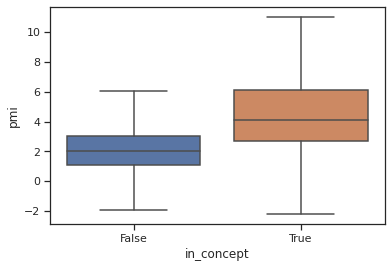

In [35]:
import seaborn as sns
sns.boxplot(x='in_concept', y='pmi', data=data, showfliers=False)

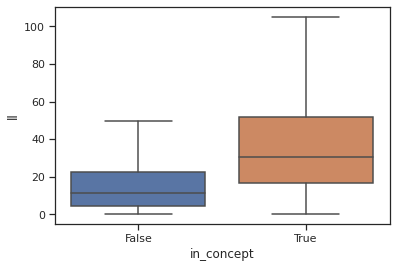

In [36]:
sns.boxplot(x='in_concept', y='ll', data=data, showfliers=False)

In [37]:
# we can perform t-tests etc.

In [38]:
from scipy import stats

In [39]:
import pingouin
pingouin.mwu(data[data['in_concept'] == True]['pmi'],
             data[data['in_concept'] == False]['pmi'])

,U-val,tail,p-val,RBC,CLES
MWU,213095110.5,two-sided,0.0,-0.546,0.773


In [40]:
data.sort_values('ll', ascending=False)

,bigram,in_concept,pmi,ll,freq
14209,"(nf-kappa, b)",True,4.989393,1.097984e+04,1077
27570,"(t, cell)",True,3.769280,1.088198e+04,1575
10704,"(transcription, factor)",True,4.508931,8.035224e+03,980
19160,"(of, the)",True,1.517641,6.538910e+03,3705
9416,"(cell, line)",True,3.814526,4.842576e+03,697
...,...,...,...,...,...
34960,"(sufficient, ,)",False,-0.000756,1.780601e-06,2
355,"(,, fibroblast)",False,-0.000756,1.780601e-06,2
30885,"(cell, at)",False,0.000330,1.559469e-06,13
13306,"(with, nf-kappa)",False,0.000212,4.532176e-07,9


Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [41]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries.


In [42]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    
    data_dict['type'].append(bigram_type)


data = pd.DataFrame(data_dict)

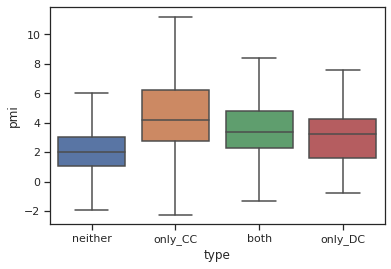

In [43]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

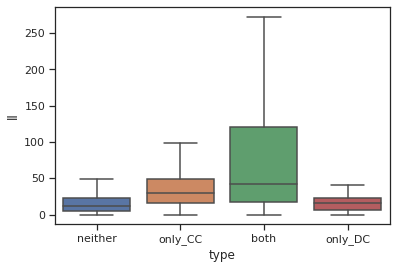

In [44]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [45]:
pingouin.kruskal(data, 'll', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,3,5329.757,0.0


In [46]:
# However, notice that
len(data[data['type'] == 'only_DC'])

43

In [47]:
# compared to e.g.
len(data[data['type'] == 'both'])

936

## Question 3: What is the association across the gap?

In [48]:
from collections import defaultdict

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_tokens()
    norm_concept = dc.normalized_concept()
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)
        else:
            cont_bigrams[bigram].append(dc)

In [49]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'type': []}

all_bigrams = set(gap_bigrams.keys()).union(set(cont_bigrams.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD:
        continue

    data_dict['bigram'].append(bigram)
    data_dict['freq'].append(model.freq(bigram))

    contingency_table = model.contingency_table(bigram[0], bigram[1])
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    else:
        type_ = 'only_cont'
    data_dict['type'].append(type_)

data = pd.DataFrame(data_dict)

### NOTE

That a bigram occurs as `only_gap` means that it occurs only in gap position for DC's. However, those bigrams can just as well occur in CC's as well, thereby getting a high association.

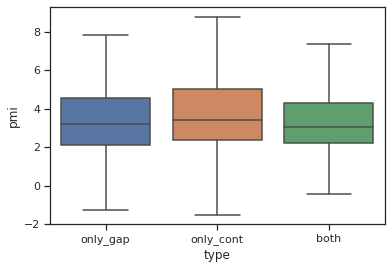

In [50]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

In [52]:
len(data[data['type'] == 'only_gap'])

362

In [26]:
pingouin.kruskal(data, 'pmi', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,2,5.037,0.080566


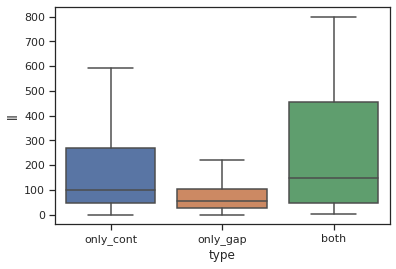

In [27]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [28]:
data[data['type'] == 'only_cont'].sort_values(['pmi', 'll'], ascending=False)

,bigram,freq,pmi,ll,type
397,"(tetanus, toxoid)",5,10.763770,133.381513,only_cont
335,"(acetyl, transferase)",9,10.042452,203.659682,only_cont
478,"(squirrel, monkey)",15,9.625153,316.760035,only_cont
161,"(k+, channel)",10,9.598766,212.262071,only_cont
592,"(leucine, zipper)",6,9.531626,128.034776,only_cont
...,...,...,...,...,...
9,"(lymphocyte, cell)",6,-0.784337,5.784182,only_cont
108,"(a, ()",36,-0.929323,45.766798,only_cont
508,"((, a)",24,-1.321365,72.986722,only_cont
57,"(t, ()",5,-1.495857,23.906769,only_cont


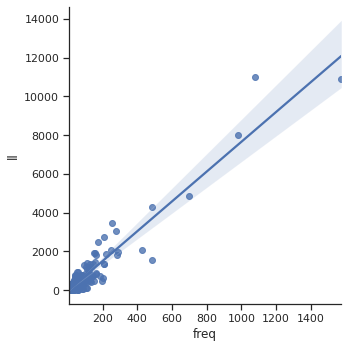

In [29]:
sns.lmplot('freq', 'll', data)

## Question 4: What is the full-term unithood?

In [53]:
all_concepts = disc_concepts.union(cont_concepts)

In [54]:
data_dict = {'concept': [], 'type': [],  'pmi_nl': [], 'tc': [], 'freq': [], 'len': []}

for concept in all_concepts:
    
    if model[concept] < FREQ_THRESHOLD:
        continue
    
    data_dict['concept'].append(concept)
    
    data_dict['freq'].append(model[concept])
    
    if concept in disc_concepts:
        if concept in cont_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_DC'
    else:
        concept_type = 'only_CC'
    data_dict['type'].append(concept_type)
    
    data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(concept, model))
    data_dict['tc'].append(conceptstats.term_coherence(concept, model))
    
    data_dict['len'].append(len(concept))


data = pd.DataFrame(data_dict)

In [55]:
data.sort_values('tc', ascending=False).head(50)

,concept,type,pmi_nl,tc,freq,len
3661,"(nf-kappa, b)",only_CC,4.990988,1.797796,1077,2
6187,"(peripheral, blood)",only_CC,6.668685,1.742202,257,2
6025,"(mobility, shift)",only_CC,7.380431,1.694980,148,2
1708,"(electrophoretic, mobility)",only_CC,7.650202,1.640819,118,2
1854,"(12-myristate, 13-acetate)",only_CC,8.795946,1.522634,48,2
2108,"(zinc, finger)",only_CC,8.663115,1.512410,52,2
793,"(transcription, factor)",both,4.509866,1.435554,980,2
6744,"(bone, marrow)",only_CC,8.819017,1.404783,43,2
6846,"(phorbol, ester)",only_CC,7.391776,1.395424,119,2
5325,"(electrophoretic, mobility, shift)",only_CC,7.555339,1.333979,110,3


In [56]:
len(data[(data['pmi_nl'] < 2) & (data['len'] == 2)]) / len(data)

0.061337287678619574

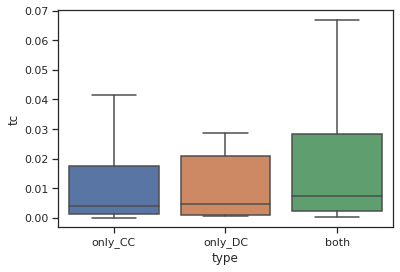

In [58]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [59]:
data_dict = {'ngram': [], 'freq': [], 'type': [], 'tc': [], 'pmi_nl': [], 'len': []}

for n in range(2, 11):
    for ngram, count in model.iterate(n, 2):
        
        ngram = tuple(ngram.split())

        data_dict['ngram'].append(ngram)

        data_dict['freq'].append(model[ngram])

        if ngram in disc_concepts:
            if ngram in cont_concepts:
                ngram_type = 'both'
            else:
                ngram_type = 'only_DC'
        elif ngram in cont_concepts:
            ngram_type = 'only_CC'
        else:
            ngram_type = 'neither'
            
        data_dict['type'].append(ngram_type)

        data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(ngram, model, smoothing=1))
        data_dict['tc'].append(conceptstats.term_coherence(ngram, model))

        data_dict['len'].append(len(ngram))
        
data = pd.DataFrame(data_dict)

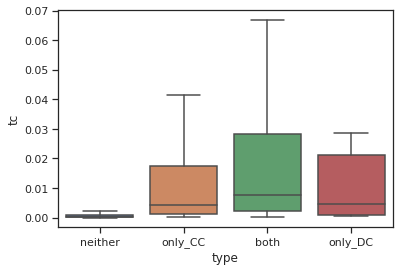

In [62]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [63]:
pingouin.pairwise_ttests

<function pingouin.pairwise.pairwise_ttests(data=None, dv=None, between=None, within=None, subject=None, parametric=True, marginal=True, alpha=0.05, tail='two-sided', padjust='none', effsize='hedges', correction='auto', nan_policy='listwise', return_desc=False, interaction=True)>